### Protein Family Classification

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from lazy import lazy
from attrdict import AttrDict
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import random

In [2]:
family_classification_metadata = pd.read_table('../seminar_5/data/family_classification_metadata.tab')
family_classification_sequences = pd.read_table('../seminar_5/data/family_classification_sequences.tab')

In [3]:
family_classification_metadata.head()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
0,Q6GZX4,001R_FRG3G,Putative transcription factor 001R,Pox_VLTF3,Poxvirus Late Transcription Factor VLTF3 like
1,Q6GZX3,002L_FRG3G,Uncharacterized protein 002L,DUF230,Poxvirus proteins of unknown function
2,Q6GZX0,005R_FRG3G,Uncharacterized protein 005R,US22,US22 like
3,Q91G88,006L_IIV6,Putative KilA-N domain-containing protein 006L,DUF3627,Protein of unknown function (DUF3627)
4,Q197F3,007R_IIV3,Uncharacterized protein 007R,DUF2738,Protein of unknown function (DUF2738)


In [4]:
family_classification_sequences.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


#### Task:
    
Use your ProtVec embedding from homework 5 to perform protein family classification using RNN.

* use 1000 most frequent families for classification
* validate your results on the train-test split
* reduce the dimensionality of the protein-space using Stochastic Neighbor Embedding and visualize two most frequent classes
* compare your RNN results with SVM

#### Let's read the embedding matrix from the original article data.

In [5]:
table = pd.read_csv('data/protVec_100d_3grams_without_quotes.csv', sep='\t', header=None)
table = table.T
header = table.iloc[0] # grab the first row for the header
prot2vec = table[1:] # take the data less the header row
prot2vec.columns = header # set the header row as the df header
prot2vec["AAA"].head()

1    -0.17406
2   -0.095756
3    0.059515
4    0.039673
5   -0.375934
Name: AAA, dtype: object

#### Let's find 1000 most frequent families.

In [6]:
most_common_families = Counter(family_classification_metadata['FamilyID']).most_common(1000)
most_common_families = [family for (family, count) in most_common_families]
family2num = {f: i for (i, f) in enumerate(most_common_families)}
family2num

{'MMR_HSR1': 0,
 'Helicase_C': 1,
 'ATP-synt_ab': 2,
 '7tm_1': 3,
 'AA_kinase': 4,
 'AAA': 5,
 'tRNA-synt_1': 6,
 'tRNA-synt_2': 7,
 'MFS_1': 8,
 'HSP70': 9,
 'Oxidored_q1': 10,
 'His_biosynth': 11,
 'Cpn60_TCP1': 12,
 'EPSP_synthase': 13,
 'Aldedh': 14,
 'Shikimate_DH': 15,
 'GHMP_kinases_N': 16,
 'Ribosomal_S2': 17,
 'Ribosomal_S4': 18,
 'Ribosomal_L16': 19,
 'KOW': 20,
 'UPF0004': 21,
 'Ribosom_S12_S23': 22,
 'GHMP_kinases_C': 23,
 'Ribosomal_S14': 24,
 'Ribosomal_S11': 25,
 'UVR': 26,
 'Ribosomal_L33': 27,
 'BRCT': 28,
 'RF-1': 29,
 'Ank_2': 30,
 'Ribosomal_L20': 31,
 'RNA_pol_Rpb2_1': 32,
 'Ribosomal_S18': 33,
 'ATP-synt_B': 34,
 'Peptidase_M20': 35,
 'Ribosomal_L18e': 36,
 'GIDA': 37,
 'Oxidored_q2': 38,
 'Ldh_1_N': 39,
 'HD': 40,
 'Ribosomal_S10': 41,
 'PALP': 42,
 'Ribosomal_L18p': 43,
 'Ribosomal_L3': 44,
 'tRNA-synt_1g': 45,
 'UbiA': 46,
 'Ribosomal_L4': 47,
 'Ribosomal_S13': 48,
 'Ribosomal_S16': 49,
 'Methyltransf_5': 50,
 'Ribosomal_L32p': 51,
 'EF_TS': 52,
 'THF_DHG_CYH':

#### Let's determine what protein length we should consider.

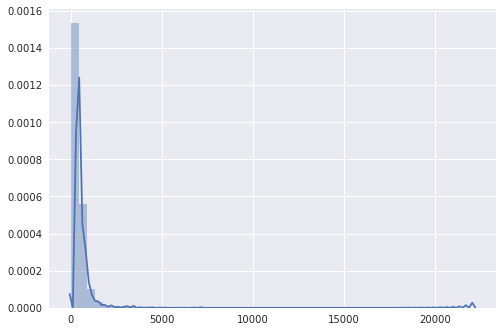

In [7]:
seq_lens = [len(i) for i in family_classification_sequences["Sequences"]]
sns.distplot(seq_lens);

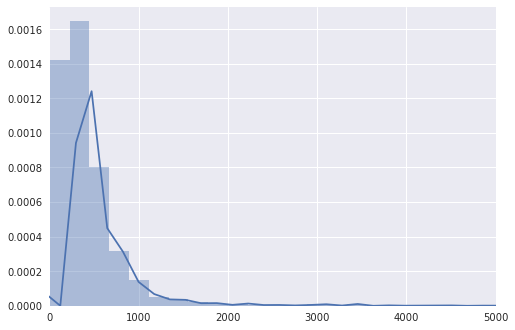

In [8]:
sns.distplot(seq_lens, bins=100).set(xlim=(0, 5000));

In [9]:
MAX_PROTEIN_LEN = 501

#### Now we'll generate batches.

In [10]:
all_proteins = family_classification_sequences['Sequences']
all_families = family_classification_metadata['FamilyID']

selected_ids = [i for i in range(len(all_proteins)) 
                  if all_families[i] in family2num and len(all_proteins[i]) <= MAX_PROTEIN_LEN]

random.shuffle(selected_ids)

train_ratio = 0.9
num_train = int(len(selected_ids) * train_ratio)

train_ids = selected_ids[:num_train]
test_ids = selected_ids[num_train:]

In [11]:
EMBED_LEN = 100
NUM_CLASSES = 1000
BATCH_SIZE = 128

In [12]:
def embedding(protein):
    res = np.zeros((MAX_PROTEIN_LEN // 3, EMBED_LEN))
    for i in range(0, (len(protein) - 3) // 3):
        try:
            res[i] = prot2vec[protein[i*3: i*3 + 3]]
        except KeyError:
            res[i] = prot2vec['<unk>']

    return res
    
embedding(all_proteins[selected_ids[0]])

array([[-0.098772, -0.131638, -0.145519, ..., -0.065224, -0.037585,
        -0.187173],
       [ 0.01193 , -0.034541, -0.023654, ..., -0.081972,  0.061456,
         0.13207 ],
       [-0.048559,  0.017829,  0.043389, ...,  0.038055,  0.13303 ,
         0.111015],
       ..., 
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ]])

In [13]:
def batches(steps):
    for i in range(steps):
        cur_ids = random.sample(train_ids, BATCH_SIZE)
        
        cur_proteins = [embedding(p) for p in all_proteins[cur_ids]]
        
        fam_ids = [family2num[f] for f in all_families[cur_ids]]
        cur_families = np.eye(NUM_CLASSES)[fam_ids]
        
        yield cur_proteins, cur_families

#### Model

In [14]:
class SequenceClassificationModel:
    
    def __init__(self, params):
        self.params = params
        self._create_placeholders()
        self.prediction
        self.cost
        self.error
        self.optimize
        #self._create_summaries()
    
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.data = tf.placeholder(tf.float32, [None, self.params.seq_length, self.params.embed_length])
            self.target = tf.placeholder(tf.float32, [None, NUM_CLASSES]) #####

    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.cost)
            tf.summary.scalar('error', self.error)
            self.summary = tf.summary.merge_all()
            saver = tf.train.Saver()     
            
    @lazy
    def length(self):
    # lengths of sequences in the current data batch    
        with tf.name_scope("seq_length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
        return length
    
    @lazy
    def prediction(self):
        with tf.name_scope("recurrent_layer"):
            output, _ = tf.nn.dynamic_rnn(
                self.params.rnn_cell(self.params.rnn_hidden),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length
            )
        last = self._last_relevant(output, self.length)

        with tf.name_scope("softmax_layer"):
            num_classes = int(self.target.get_shape()[1])
            weight = tf.Variable(tf.truncated_normal(
                [self.params.rnn_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
        return prediction
    
    @lazy
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.target * tf.log(self.prediction))
        return cross_entropy
    
    @lazy
    def error(self):
        self.mistakes = tf.not_equal(
            tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
    
    @lazy
    def optimize(self):
    # we will limit the maximum weight updates for gradient clipping
        with tf.name_scope("optimization"):
            gradient = self.params.optimizer.compute_gradients(self.cost)
            if self.params.gradient_clipping:
                limit = self.params.gradient_clipping
                gradient = [
                    (tf.clip_by_value(g, -limit, limit), v)
                    if g is not None else (None, v)
                    for g, v in gradient]
            optimize = self.params.optimizer.apply_gradients(gradient)
        return optimize
    
    @staticmethod
    def _last_relevant(output, length):
        with tf.name_scope("last_relevant"):
            batch_size = tf.shape(output)[0]
            max_length = int(output.get_shape()[1])
            output_size = int(output.get_shape()[2])
            index = tf.range(0, batch_size) * max_length + (length - 1)
            flat = tf.reshape(output, [-1, output_size])
            relevant = tf.gather(flat, index)
        return relevant

In [15]:
params = AttrDict(
    rnn_cell=tf.contrib.rnn.GRUCell,
    rnn_hidden=300,
    optimizer=tf.train.AdamOptimizer(0.002),
    batch_size=BATCH_SIZE,
    gradient_clipping=100,
    seq_length=MAX_PROTEIN_LEN//3,
    embed_length=EMBED_LEN
)

In [ ]:
tf.reset_default_graph()
model = SequenceClassificationModel(params)

#### Training and testing

In [ ]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
gpu_config = tf.ConfigProto(gpu_options=gpu_options)

NUM_STEPS = 1000

with tf.Session(config=gpu_config) as sess:

    sess.run(tf.global_variables_initializer())
    
    for index, batch in enumerate(batches(NUM_STEPS)):
        feed = {model.data: batch[0], model.target: batch[1]}
        error, _ = sess.run([model.error, model.optimize], feed)
        
        if index % 50 == 0:
            print('Accuracy on step {}: {:3.1f}%'.format(index + 1, 100 * (1 - error)))
            
    # Testing
    # I run model on a one sample at time because otherwise I had problems with memory.
    sum_error = 0
    for i in range(len(test_ids)):
        if i % 1000 == 0:
            print(i, end='_')
        cur_id = [test_ids[i]]
        test_proteins = [embedding(p) for p in all_proteins[cur_id]]

        test_fam_ids = [family2num[f] for f in all_families[cur_id]]
        test_families = np.eye(NUM_CLASSES)[test_fam_ids]

        feed = {model.data: test_proteins, model.target: test_families}
        error = sess.run(model.error, feed)
        sum_error += error

Accuracy on step 1: 0.0%
Accuracy on step 51: 0.0%
Accuracy on step 101: 1.6%
Accuracy on step 151: 7.8%
Accuracy on step 201: 10.2%
Accuracy on step 251: 9.4%
Accuracy on step 301: 18.0%
Accuracy on step 351: 23.4%
Accuracy on step 401: 22.7%
Accuracy on step 451: 28.9%
Accuracy on step 501: 39.1%
Accuracy on step 551: 45.3%
Accuracy on step 601: 43.0%
Accuracy on step 651: 59.4%
Accuracy on step 701: 64.8%
Accuracy on step 751: 64.1%
Accuracy on step 801: 62.5%
Accuracy on step 851: 66.4%
Accuracy on step 901: 74.2%
Accuracy on step 951: 65.6%
0_1000_2000_3000_4000_5000_6000_7000_8000_9000_10000_11000_12000_13000_14000_15000_16000_17000_

In [ ]:
print('\nAccuracy on test set: {:3.1f}%'.format(100 * (1 - sum_error/len(test_ids))))